In [51]:
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import joblib
import pickle


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from IPython.display import Image
from sklearn.svm import SVC
from sklearn import tree


if tf.__version__.startswith("2."):
    import tensorflow.compat.v1 as tf
    tf.compat.v1.disable_v2_behavior()
    tf.compat.v1.disable_eager_execution()
    print("Enabled compatitility to tf1.x")

Enabled compatitility to tf1.x


In [5]:
class NaiveModel():
    def __init__(self):
        self.true_frequencies = {}
        self.false_frequencies = {}

    def fit(self, x_train, y_train):
        true_registers = x_train[y_train==1]
        false_registers = x_train[y_train==0]

        true_prior = len(true_registers)/len(x_train)
        false_prior = len(false_registers)/len(x_train)

        self.true_frequencies = {col:{index: row[0]/len(true_registers) for index, row in  pd.DataFrame(true_registers[col].value_counts()).iterrows()} for col in true_registers.columns}
        self.false_frequencies = {col:{index: row[0]/len(false_registers) for index, row in  pd.DataFrame(false_registers[col].value_counts()).iterrows()} for col in false_registers.columns}

    def predict(self, x):

        positive_predictions = x.apply(lambda row: np.prod([self.true_frequencies[col].get(row[col], 0.001) for col in x.columns]), axis=1)
        negative_predictions = x.apply(lambda row: np.prod([self.false_frequencies[col].get(row[col], 0.001) for col in x.columns]), axis=1)

        return (positive_predictions > negative_predictions) * 1

Camino del Arbol de decision


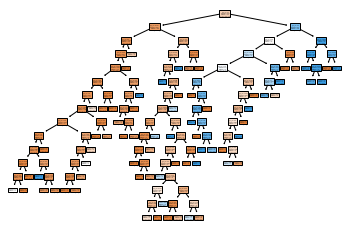

Prediccion Naive Bayer
1
Prediccion Logistica
1.0
Prediccion Final Combinada
1


In [58]:
class LogisticClassificator():
    def __init__(self, w, b):
        self.w = w
        self.b = b
        
    def predict(self, x):
        x = np.array(x).astype(np.float32)

        with tf.Graph().as_default():
            weights = tf.constant(self.w)
            biases = tf.constant(self.b)
            x_ = tf.constant(x)

            prediction = tf.round(tf.sigmoid(tf.matmul(x_, weights)+biases))
            init = tf.global_variables_initializer()

            with tf.compat.v1.Session() as session:
                init = tf.global_variables_initializer()
                predictions = prediction.eval()
                return predictions.reshape(-1)

class Ensembled:
    def __init__(self,dt_conf, svm_conf, naive_conf, lg_conf):
        self.configurations = {"dt": dt_conf,
                               "svm": svm_conf,
                               "naive": naive_conf,
                               "lg": lg_conf}
        self.dt_model = self.load_decision_tree(dt_conf)
        self.svm_model = self.load_svm(svm_conf)
        self.naive_model = self.load_naive(naive_conf)
        self.lg_model = self.load_lg(lg_conf)
        
    def load_decision_tree(self, conf):
        return joblib.load(f"experimentos/{conf}.pkl")

    def load_svm(self, conf):
        return joblib.load(f"experimentos/{conf}.pkl")

    def load_naive(self, conf):
        return joblib.load(f"experimentos/{conf}.pkl")

    def load_lg(self, conf):
        pr = np.load(f"experimentos/{conf}.npy", allow_pickle=True)
        return LogisticClassificator(pr[0], pr[1])
    
    def subsetting_features(self, params, x):
        params['features'] = [x.columns[int(col_index)] for col_index in params['features'].split(',')]
        return x[params['features']]
    
    def predict(self, x):
        # Setting the X dataset to the selected features during training
        x_dt = x
        x_svm = x
        x_naive_params = self.params_parser(self.configurations['naive'])
        x_naive = self.subsetting_features(x_naive_params, x)
        x_lg_params = self.params_parser(self.configurations['lg'])
        x_lg = self.subsetting_features(x_lg_params, x)
        
        print("Camino del Arbol de decision")
        plt.figure()
        tree.plot_tree(ensembled.dt_model, filled=True) 
        plt.show()
        
        print("Prediccion Naive Bayer")
        print(int(self.naive_model.predict(x_naive)))
        
        print("Prediccion Logistica")
        print(self.lg_model.predict(x_lg)[0])
        
        print("Prediccion Final Combinada")
        print(self.most_popular_prediction(self.dt_model.predict(x_dt),
                                           self.svm_model.predict(x_svm),
                                           self.naive_model.predict(x_naive),
                                           self.lg_model.predict(x_lg)))
        
    def most_popular_prediction(self, pred1, pred2, pred3, pred4):
        matrix_predictions = np.array([pred1, pred2, pred3, pred4])
        sum_predictions = np.sum(matrix_predictions, axis=0)[0]
        return (sum_predictions >= 2) * 1
        
    def params_parser(self, conf_string: str):
        params = conf_string.split('_')
        return {**{'model': params[0], 'plain_conf': conf_string}, **{param.split('=')[0]: param.split('=')[1] for param in params[1:]}}

        
ensembled = Ensembled('decisiontree_splitter=best_maxdepth=220_minsamplessplit=10_criterion=entropy',
                     'svm_kernel=linear_degree=2_gamma=scale',
                     'naivebayes_features=0,4,5',
                     'lg_batchsize=32_epochs=900_regfactor=0.01_verbose=1000_lr=0.001_features=0,3,4,5')


x_test = pd.read_csv('x_test.csv', index_col=0)
ensembled.predict(x_test[0:1])

Camino del Arbol de decision


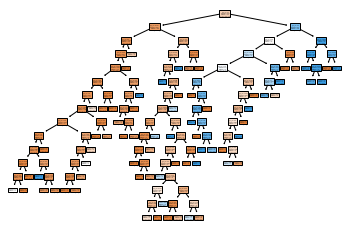

Prediccion Naive Bayer
1
Prediccion Logistica
1.0
Prediccion Final Combinada
1


In [60]:
x_test = pd.read_csv('x_test.csv', index_col=0)
ensembled.predict(x_test[0:1])

Camino del Arbol de decision


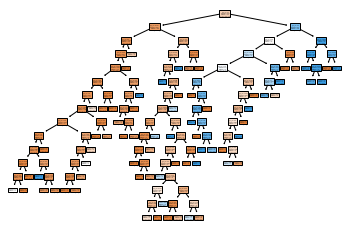

Prediccion Naive Bayer
0
Prediccion Logistica
0.0
Prediccion Final Combinada
0


In [61]:
x_test = pd.read_csv('x_test.csv', index_col=0)
ensembled.predict(x_test[1:2])

Camino del Arbol de decision


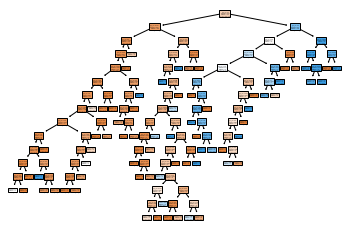

Prediccion Naive Bayer
0
Prediccion Logistica
0.0
Prediccion Final Combinada
0


In [62]:
x_test = pd.read_csv('x_test.csv', index_col=0)
ensembled.predict(x_test[2:3])

Camino del Arbol de decision


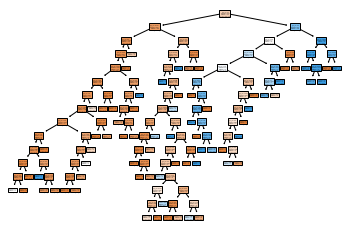

Prediccion Naive Bayer
1
Prediccion Logistica
1.0
Prediccion Final Combinada
1


In [63]:
x_test = pd.read_csv('x_test.csv', index_col=0)
ensembled.predict(x_test[3:4])

Camino del Arbol de decision


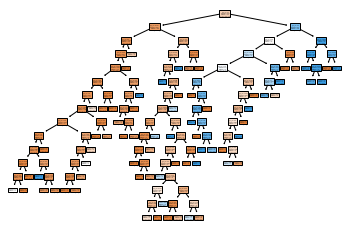

Prediccion Naive Bayer
0
Prediccion Logistica
0.0
Prediccion Final Combinada
0


In [64]:
x_test = pd.read_csv('x_test.csv', index_col=0)
ensembled.predict(x_test[4:5])

Camino del Arbol de decision


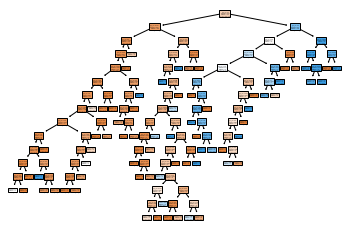

Prediccion Naive Bayer
0
Prediccion Logistica
0.0
Prediccion Final Combinada
0


In [65]:
x_test = pd.read_csv('x_test.csv', index_col=0)
ensembled.predict(x_test[5:6])

Camino del Arbol de decision


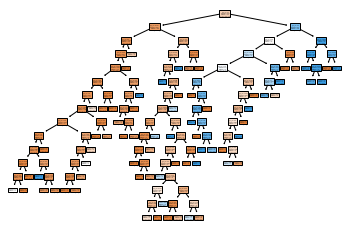

Prediccion Naive Bayer
0
Prediccion Logistica
0.0
Prediccion Final Combinada
0


In [66]:
x_test = pd.read_csv('x_test.csv', index_col=0)
ensembled.predict(x_test[6:7])

Camino del Arbol de decision


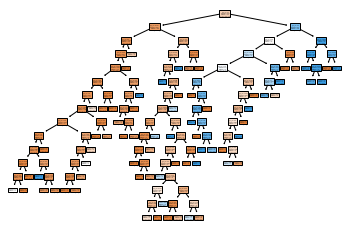

Prediccion Naive Bayer
0
Prediccion Logistica
0.0
Prediccion Final Combinada
0


In [67]:
x_test = pd.read_csv('x_test.csv', index_col=0)
ensembled.predict(x_test[7:8])

Camino del Arbol de decision


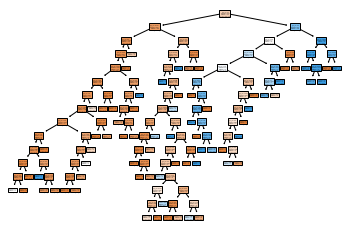

Prediccion Naive Bayer
0
Prediccion Logistica
0.0
Prediccion Final Combinada
0


In [68]:
x_test = pd.read_csv('x_test.csv', index_col=0)
ensembled.predict(x_test[8:9])

Camino del Arbol de decision


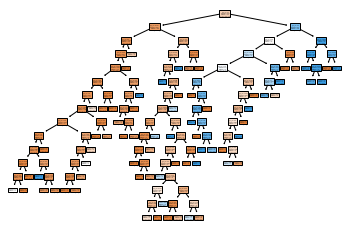

Prediccion Naive Bayer
0
Prediccion Logistica
0.0
Prediccion Final Combinada
0


In [69]:
x_test = pd.read_csv('x_test.csv', index_col=0)
ensembled.predict(x_test[9:10])